# iFFT to create signal with given Spectrum

In [1]:
import requests as req
try:
    %run basic_material.py
    print('Basic file found')
except:    
    print('Basic not file found - downloading it')
    url = "https://raw.githubusercontent.com/JonHowMIT/Signals_and_Systems/main/basic_material.py"
    res = req.get(url)
    file = open('basic_material.py', 'w')
    file.write(res.text)
    file.close()


Running Python: 3.8.12
Running Sympy: 1.11.1
Basic file found
Defaulting to user installation because normal site-packages is not writeable


## Set Parameters

In [18]:
Td = 2
fs = 44100
N = 2**(1+round(np.log2(Td*fs)))
T = N/fs
t = np.arange(N)*T/N
delta_freq = fs/N

In [19]:
# bounds of rect in Y(f)
f_low = 5000
f_high = 16000
# find equivalent positions in Y(f) 
n_low = int(f_low/delta_freq)
n_high = int(f_high/delta_freq)
L1 = np.arange(n_low,n_high)

## Create Y(f) and y[n]

In [20]:
Y_bl = np.zeros((N,), dtype=complex)
# create random phase needed for correct ifft process
rng = np.random.default_rng()
phi = rng.uniform(0, 2*np.pi, (len(L1),))

# create Y(f)
if (0):
    mag_temp = np.sin(np.pi*np.arange(0,n_high-n_low)/(n_high-n_low))
else:
    mag_temp = np.ones([1,n_high-n_low])
    
Y_bl[L1] = mag_temp*np.exp(1j*phi)
# add complex conjugate at upper end to ensure that y[n] real
Y_bl[N-L1] = np.conj(Y_bl[L1])

# create y[n]
y_bl = ifft(Y_bl)

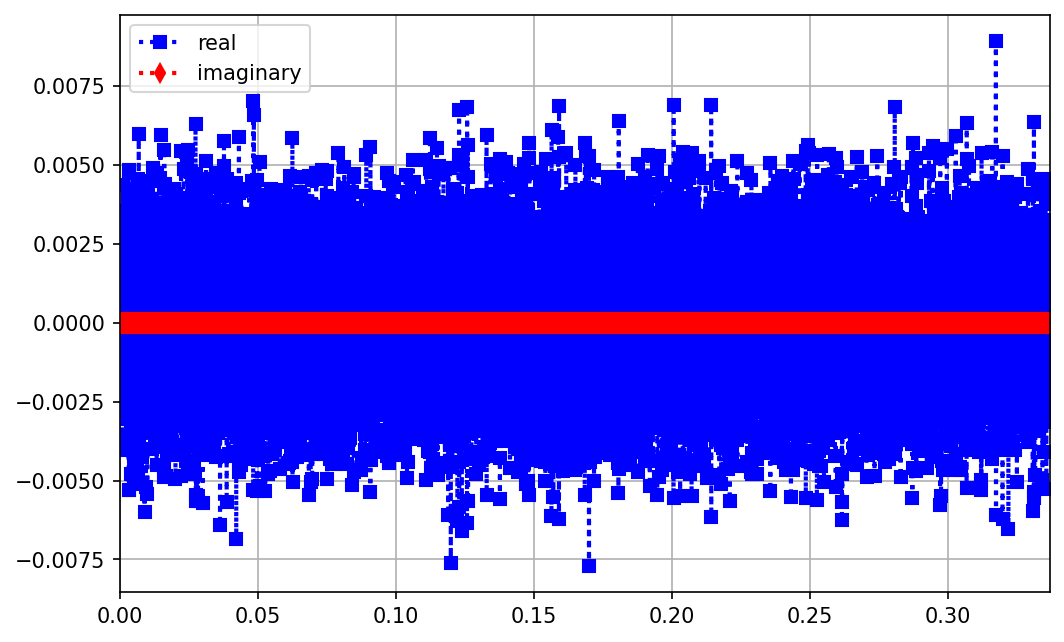

In [21]:
# check that it is real
plt.plot(t[0:n_low], y_bl.real[0:n_low], 'bs:', t[0:n_low], y_bl.imag[0:n_low], 'rd:')
plt.legend(('real', 'imaginary'))
plt.show()

## FFT the created data to confirm spectrum is right

In [22]:
Y_bl_fft = fft(y_bl)
f_bl = fftfreq(N, 1/fs)

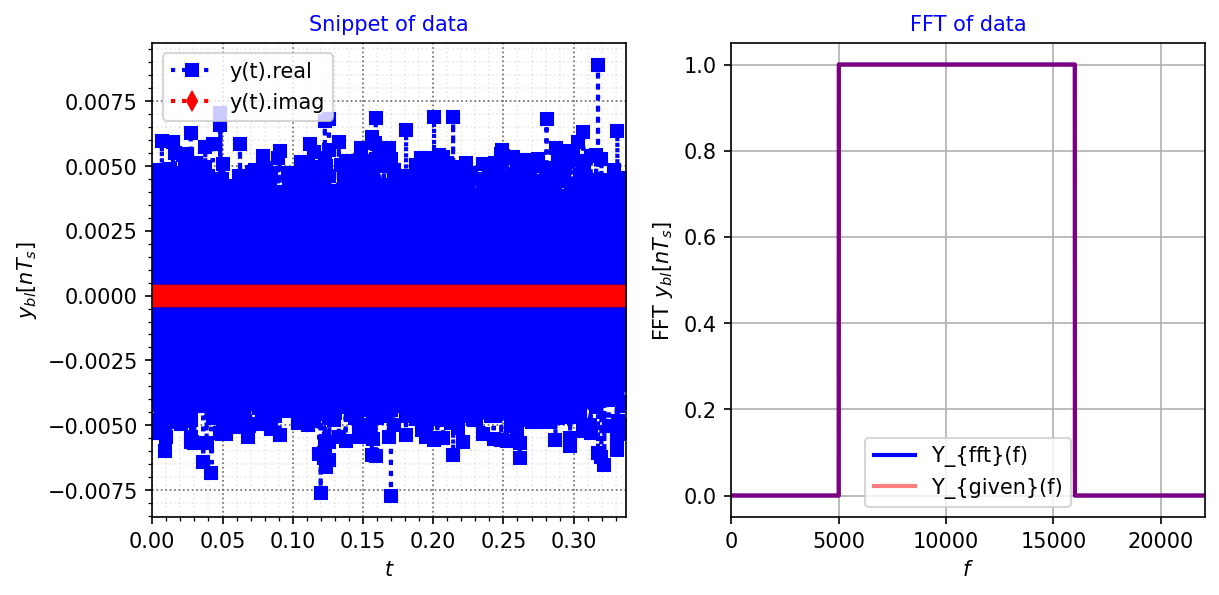

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), dpi=150)
fig.tight_layout(pad=2)
ax1.plot(t[0:n_low], y_bl.real[0:n_low], 'bs:', t[0:n_low], y_bl.imag[0:n_low], 'rd:')
ax1.set_ylabel('$y_{bl}[nT_s]$')
ax1.set_xlabel('$t$')
ax1.legend(['y(t).real','y(t).imag'])
ax1.set_title('Snippet of data')
nicegrid(ax1)

ax2.plot(f_bl[0:N//2], np.abs(Y_bl_fft[0:N//2]),'b-')
ax2.plot(f_bl[0:N//2], np.abs(Y_bl[0:N//2]),'r-',alpha=0.5)
ax2.set_ylabel('FFT $y_{bl}[nT_s]$')
ax2.set_xlabel('$f$')
ax2.set_xlim([0, fs/2])
ax2.legend(['Y_{fft}(f)','Y_{given}(f)'])
ax2.set_title('FFT of data')
plt.show()

In [24]:
import csv
f = open('data/ifft_csv_file'+'_'+str(f_low)+'_'+str(f_high)+'_'+str(fs)+'.csv', 'w')
writer = csv.writer(f)
for i in range(len(y_bl)):
    writer.writerow([np.real(y_bl[i])])
f.close()

## Apply the filters to the time data 

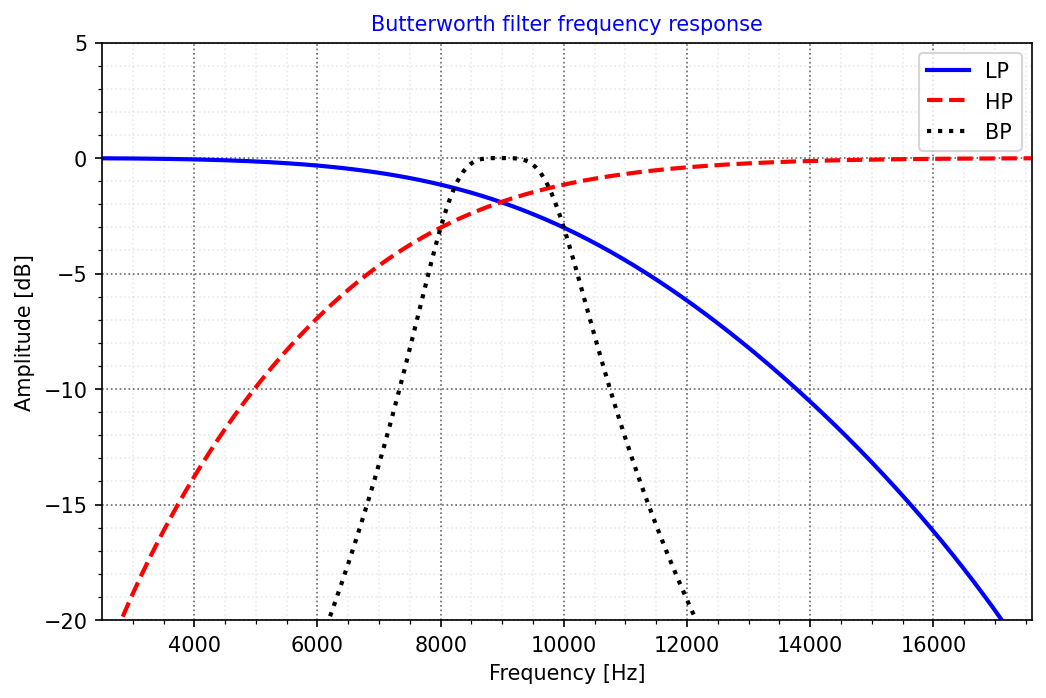

In [25]:
eps = 1e-12 # added to avoid some plotting errors
# Low Pass
b_low, a_low = signal.butter(2, 2*f_low, 'low', fs=fs)
f_lp, h_lp = signal.freqz(b_low, a_low,fs=fs,worN=1000)
# High Pass
b_high, a_high = signal.butter(2, f_high/2, 'high', fs=fs)
f_hp, h_hp = signal.freqz(b_high, a_high,fs=fs,worN=1000)
# Band Pass
b_bp, a_bp = signal.butter(2, [min(f_high/2,2*f_low),max(f_high/2,2*f_low)], 'bandpass', fs=fs)
f_bp, h_bp = signal.freqz(b_bp, a_bp,fs=fs,worN=1000)

plt.plot(f_lp, 20 * np.log10(abs(h_lp+eps)),'b-',label='LP')
plt.plot(f_hp, 20 * np.log10(abs(h_hp+eps)),'r--',label='HP')
plt.plot(f_bp, 20 * np.log10(abs(h_bp+eps)),'k:',label='BP')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.xlim([f_low/2, 1.1*f_high])
plt.ylim([-20, 5])
nicegrid()
plt.legend()
plt.show()

## Find Spectrum of filtered time data to confirm consistent with expectations

In [26]:
# Apply filters to data
yf_lp = signal.lfilter(b_low, a_low, y_bl)
yf_hp = signal.lfilter(b_high, a_high, y_bl)
yf_bp = signal.lfilter(b_bp, a_bp, y_bl)

Y_lp_fft = fft(yf_lp)
Y_hp_fft = fft(yf_hp)
Y_bp_fft = fft(yf_bp)

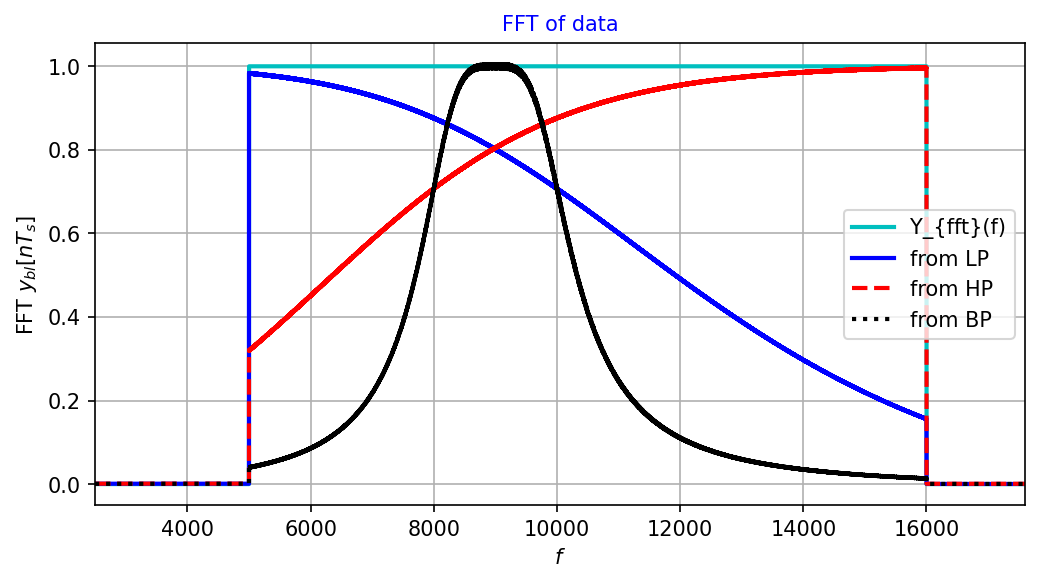

In [27]:
fig, ax1 = plt.subplots(1,1, figsize=(8,4), dpi=150)
ax1.plot(f_bl[0:N//2], np.abs(Y_bl_fft[0:N//2]),'c-')
ax1.plot(f_bl[0:N//2], np.abs(Y_lp_fft[0:N//2]),'b-')
ax1.plot(f_bl[0:N//2], np.abs(Y_hp_fft[0:N//2]),'r--')
ax1.plot(f_bl[0:N//2], np.abs(Y_bp_fft[0:N//2]),'k:')
ax1.set_ylabel('FFT $y_{bl}[nT_s]$')
ax1.set_xlabel('$f$')
ax1.set_xlim([int(f_low)/2, 1.1*int(f_high)])
ax1.legend(['Y_{fft}(f)','from LP','from HP','from BP'])
ax1.set_title('FFT of data')
plt.show()

In [28]:
from scipy.io.wavfile import write 

write("data/y_fft.wav", fs, np.real(y_bl).astype(np.float32))
ipd.Audio('data/y_fft.wav', rate = fs) 

In [29]:
write("data/yf_lp_fft.wav", fs, np.real(yf_lp).astype(np.float32))
ipd.Audio('data/yf_lp_fft.wav', rate = fs) # 

In [30]:
write("data/yf_hp_fft.wav", fs, np.real(yf_hp).astype(np.float32))
ipd.Audio('data/yf_hp_fft.wav', rate = fs) # 

In [31]:
write("data/yf_bp_fft.wav", fs, np.real(yf_bp).astype(np.float32))
ipd.Audio('data/yf_bp_fft.wav', rate = fs) # 

## Subsample at half the rate above

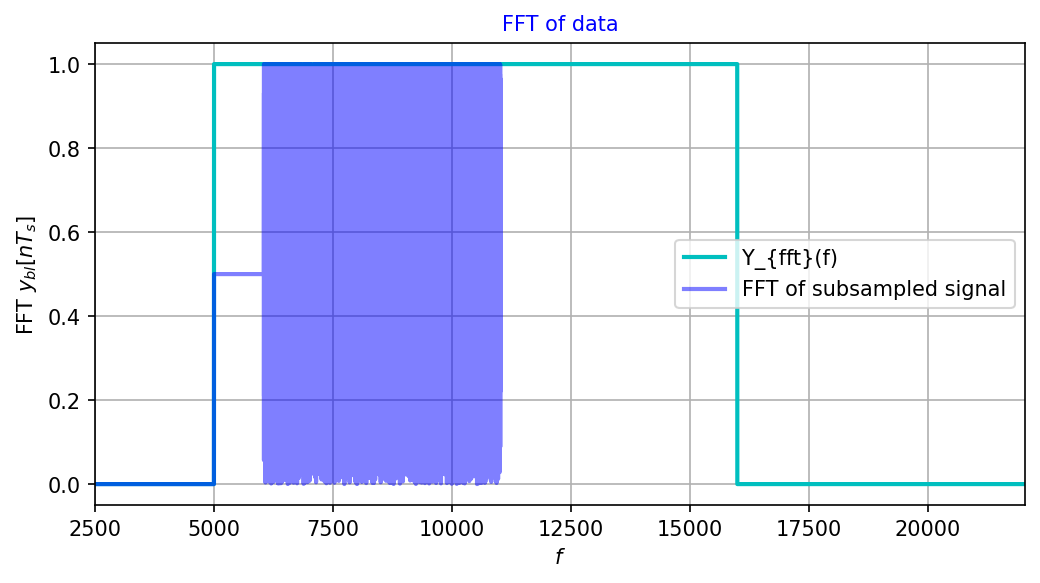

In [32]:
ss_value = 2
t_ss = t[0::ss_value]
y_ss = y_bl.real[0::ss_value]
Y_ss_fft = fft(y_ss)
f_ss = fftfreq(int(N/ss_value), 1/(fs/ss_value))

fig, ax1 = plt.subplots(1,1, figsize=(8,4), dpi=150)
ax1.plot(f_bl[0:N//2], np.abs(Y_bl_fft[0:N//2]),'c-')
ax1.plot(f_ss[0:N//(2*ss_value)], np.abs(Y_ss_fft[0:N//(2*ss_value)]),'b-',alpha=0.5)
ax1.set_ylabel('FFT $y_{bl}[nT_s]$')
ax1.set_xlabel('$f$')
ax1.set_xlim([int(f_low)/2, fs/2])
ax1.legend(['Y_{fft}(f)','FFT of subsampled signal'])
ax1.set_title('FFT of data')
plt.show()